# Practical 5
## Image Recognition using CNN and understanding calculation of shape and learnable parameters in each layer of CNN model 

### Theory :-

#### Convolutional Neural Networks (CNNs) are a class of deep learning models specifically designed for processing structured grid data, such as images. They are particularly effective for image recognition tasks due to their ability to automatically and adaptively learn spatial hierarchies of features from input images.

### Key Components of CNNs:
1. **Convolutional Layers**: These layers apply convolution operations to the input, using filters to extract features such as edges, textures, and patterns.
2. **Pooling Layers**: Pooling layers downsample the feature maps, reducing their spatial dimensions while retaining important information. This helps to make the model invariant to small translations in the input.
3. **Fully Connected Layers**: After several convolutional and pooling layers, the high-level reasoning is done through fully connected layers, which output the final class probabilities.

### Learnable Parameters:
- The learnable parameters in a CNN include the weights and biases of the convolutional and fully connected layers. The number of parameters depends on the architecture, including the number of filters, filter size, and the number of neurons in fully connected layers.

### Formulae for Calculating Output Shape and Learnable Parameters:
1. **Output Shape of Convolutional Layer**:

    - If the ```input shape is (H, W, D) (Height, Width, Depth)```, ```kernal/filter size is (F, F)```, ```number of filters is K```, ```stride is S```, ```and padding is P```, then the ```output shape (H_out, W_out, D_out)``` can be calculated as:
      ```
        -> H_out = [(H - F + 2P) / S] + 1
        -> W_out = [(W - F + 2P) / S] + 1
        -> D_out = K
      ```
    - **Learnable Parameters in Convolutional Layer** = ```(F * F * D + 1) * K``` (where +1 accounts for the bias term for each filter).

    - **Example**: For an input of shape (32, 32, 3), a filter size of (3, 3), 64 filters, stride 1, and padding 1:
      - Output shape = (32, 32, 64) (64 will be the depth or number of channels in the next layer)
      - Learnable parameters = (3 * 3 * 3 + 1) * 64 = 1,792 (hear 64 is the number of filters or channels out)

2. **Output Shape of Fully Connected Layer**:

    + If the input to the fully connected layer has ```N input units``` and ```M output units```,
    * ```Output shape = M * 1 ==> (M,)```
    - **Learnable Parameters for Fully Connected Layer** = ```(N * M) + M.``` 
3. **Output Shape of Pooling Layer**:
    - For a pooling layer with ```filter size (F, F)```, ```stride S```, and ```input shape (H, W, D)```:
      ```
        -> H_out = (H - F) / S + 1
        -> W_out = (W - F) / S + 1
        -> D_out = D (depth remains the same)
      ```
    - **Learnable Parameters**: _0_ (```Pooling layers do not have learnable parameters```).
4. **Total Learnable Parameters** : Summation of all learnable parameters obtained 

---

### **About Dataset**

For this experiment, we use the **Celebrity Face Recognition Dataset** available on Kaggle:

🔗 [Celebrity Face Recognition Dataset](https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset/data)

* **Total Images**: 2,562
* **Number of Classes**: 31 (each representing a different celebrity)
* **Data Type**: Colored face images
* **Applications**:

  * Face recognition tasks
  * CNN-based classification experiments
  * Transfer learning and fine-tuning

This dataset is well-suited for **image recognition using CNNs**, as it contains multiple classes with sufficient samples to train and evaluate deep learning models.

---

## Software Used 
- Python (3.x)
- Jupyter-Lab
- Kaggle
- GitHub Codespaces
## Libraries Used
- Pandas
- Matplotlib
- OpenCV-Python
- Pillow
- Os
- Numpy
- Scikit-Learn (Sklearn)
- Kagglehub
- Tensorflow
---

### Downlooading dataset 

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vasukipatel/face-recognition-dataset")

print("Path to dataset files:", path)

Mounting files to /kaggle/input/face-recognition-dataset...
Path to dataset files: /kaggle/input/face-recognition-dataset


### Importing Libraries

In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Rescaling,Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense, AlphaDropout, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import LecunNormal
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

2025-09-07 15:33:13.605980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757259193.877842      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757259193.962059      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading Dataset

In [9]:
try:
    # Attempt to load from the Kaggle dataset path first
    df = pd.read_csv('/kaggle/input/face-recognition-dataset/Dataset.csv')
except FileNotFoundError:
    # If that fails, try loading from the current directory
    df = pd.read_csv('Dataset.csv')

### About Dataset

In [13]:
df.describe()

,id,label,filepath
count,2562,2562,2562
unique,2562,31,2562
top,Robert Downey Jr_87.jpg,Brad Pitt,/kaggle/input/face-recognition-dataset/Faces/F...
freq,1,120,1


### Conclusion : Dataset contains 2562 total image files for 31 unique classes

### Train, Test & Validation Set Generation

In [14]:
# Add full image paths if only filenames are provided
# Use a try-except block to set the correct image directory path
try:
    # This path is correct for many Kaggle datasets
    image_dir = '/kaggle/input/face-recognition-dataset/Faces/Faces'
    if not os.path.isdir(image_dir):
        # Fallback to a local path if the Kaggle one doesn't exist
        image_dir = 'Faces'
        if not os.path.isdir(image_dir):
            raise FileNotFoundError("Image directory not found in Kaggle or locally.")
except FileNotFoundError as e:
    print(e)
    # Handle the error or exit
    exit()
df['filepath'] = df['id'].apply(lambda x: os.path.join(image_dir, x))
class_mode='sparse'#'categorical'
batch=32
# Split dataset into train+val and test sets (e.g., 80-20 split)
train_val_df, test_df = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=42)

# Split train_val into train and validation sets (e.g., 80-20 split of train_val)
train_df, val_df = train_test_split(train_val_df, test_size=0.20, stratify=train_val_df['label'], random_state=42)

# Define ImageDataGenerators with preprocessing and augmentation for training only
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(160, 160),
    batch_size=batch,
    class_mode=class_mode,
    color_mode='grayscale',
    shuffle=True)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(160, 160),
    batch_size=batch,
    class_mode=class_mode,
    color_mode='grayscale',
    shuffle=False)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(160, 160),
    batch_size=batch,
    class_mode=class_mode,
    color_mode='grayscale',
    shuffle=False)
num_classes = len(train_generator.class_indices)

Found 1639 validated image filenames belonging to 31 classes.
Found 410 validated image filenames belonging to 31 classes.
Found 513 validated image filenames belonging to 31 classes.


In [16]:
train_generator.allowed_class_modes

{None, 'binary', 'categorical', 'input', 'multi_output', 'raw', 'sparse'}

In [15]:
train_generator.class_mode

'sparse'

### Define a simple CNN architecture

In [ ]:
model = Sequential([
    Input(shape=(160, 160, 1)),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    #BatchNormalization(),
    Dense(128, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.5),
    #AlphaDropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer for classification
])

model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())
print(model.get_config()) # sparse_categorical_crossentropy

2025-09-07 15:41:39.699555: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 204800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    52,429,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,614,815 (200.71 MB)

 Trainable params: 52,614,815 (200.71 MB)

 Non-trainable params: 0 (0.00 B)

None
{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 160, 160, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'register

### Train the model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50
)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.0467 - loss: 3.9334 - val_accuracy: 0.1098 - val_loss: 3.1863
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.1411 - loss: 3.1085 - val_accuracy: 0.2220 - val_loss: 2.7314
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.2022 - loss: 2.7612 - val_accuracy: 0.2732 - val_loss: 2.4814
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.2437 - loss: 2.6458 - val_accuracy: 0.3146 - val_loss: 2.3732
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.2517 - loss: 2.5288 - val_accuracy: 0.3146 - val_loss: 2.3212
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.2766 - loss: 2.4122 - val_accuracy: 0.3829 - val_loss: 2.1794
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.3059 - loss: 2.3517 - val_accuracy: 0.3854 - val_loss: 2.0964
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 184s 4s/step - accuracy: 0.3112 - loss: 2.2654 - val_accuracy: 0.4073 - v

#### Conclusion : For batch size of 32 grayscale images over 50 epochs using Adam optimizer with learning rate 0.001 for sparse_categorical_crossentropy loss we get accuracy of 0.5789

### Plotting Accuracy & Loss Graph

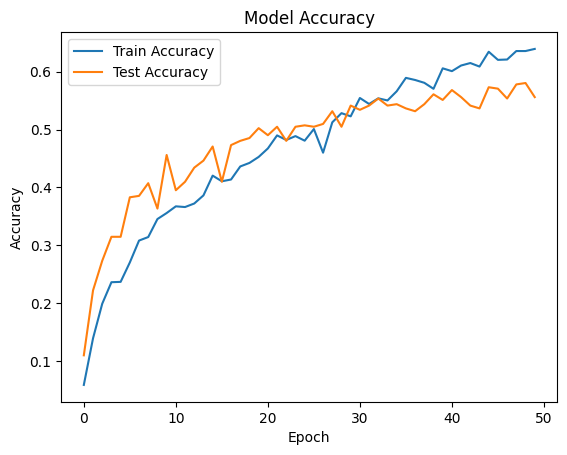

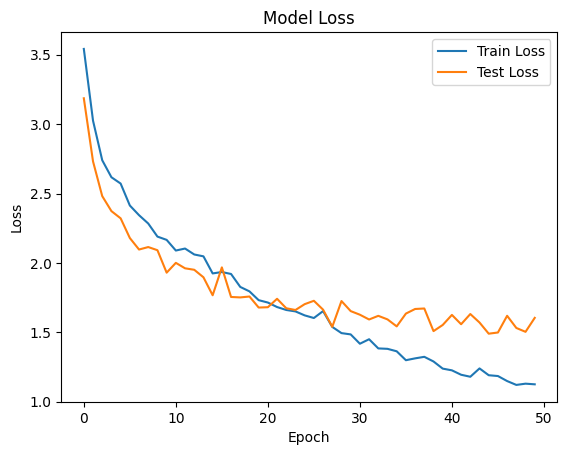

In [19]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Conclusion : Model has little overfitting approximately between epoch 40 and epoch 50

### Creating ImageDataGenerators for Testing the Model

In [22]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Correctly determine the image directory path ---
# Use a try-except block to set the correct image directory path
try:
    # Path for Kaggle
    data_dir = '/kaggle/input/face-recognition-dataset/Original Images/Original Images/'
    if not os.path.isdir(data_dir):
        # Fallback to local path if Kaggle path doesn't exist
        data_dir = 'Original_Images'
        if not os.path.isdir(data_dir):
            raise FileNotFoundError("Image directory not found in Kaggle or locally.")
except FileNotFoundError as e:
    print(e)
    # Handle the error or exit
    exit()

batch = 32
target_size = (160, 160)

# Define ImageDataGenerators with preprocessing and augmentation for training only
# We use a single generator instance for both training and validation when using validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2   # 20% of the data will be used for validation
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch,
    class_mode='sparse',
    subset='training',           # Set as training data
    shuffle=True,
    color_mode='grayscale'
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch,
    class_mode='sparse',
    subset='validation',         # Set as validation data
    shuffle=False,                # Keep shuffle=False for reproducible validation results
    color_mode='grayscale'
)

print(f"Number of training images: {train_generator.n}")
print(f"Number of validation images: {validation_generator.n}")


Found 2060 images belonging to 31 classes.
Found 502 images belonging to 31 classes.
Number of training images: 2060
Number of validation images: 502


### List of Image Classes/Categories

In [23]:
idx2label = {v: k for k, v in train_generator.class_indices.items()}
idx2label

{0: 'Akshay Kumar',
 1: 'Alexandra Daddario',
 2: 'Alia Bhatt',
 3: 'Amitabh Bachchan',
 4: 'Andy Samberg',
 5: 'Anushka Sharma',
 6: 'Billie Eilish',
 7: 'Brad Pitt',
 8: 'Camila Cabello',
 9: 'Charlize Theron',
 10: 'Claire Holt',
 11: 'Courtney Cox',
 12: 'Dwayne Johnson',
 13: 'Elizabeth Olsen',
 14: 'Ellen Degeneres',
 15: 'Henry Cavill',
 16: 'Hrithik Roshan',
 17: 'Hugh Jackman',
 18: 'Jessica Alba',
 19: 'Kashyap',
 20: 'Lisa Kudrow',
 21: 'Margot Robbie',
 22: 'Marmik',
 23: 'Natalie Portman',
 24: 'Priyanka Chopra',
 25: 'Robert Downey Jr',
 26: 'Roger Federer',
 27: 'Tom Cruise',
 28: 'Vijay Deverakonda',
 29: 'Virat Kohli',
 30: 'Zac Efron'}

In [29]:
# Add full image paths if only filenames are provided
# Use a try-except block to set the correct image directory path
try:
    # This path is correct for many Kaggle datasets
    image_dir = '/kaggle/input/face-recognition-dataset/Faces/Faces'
    if not os.path.isdir(image_dir):
        # Fallback to a local path if the Kaggle one doesn't exist
        image_dir = 'Faces'
        if not os.path.isdir(image_dir):
            raise FileNotFoundError("Image directory not found in Kaggle or locally.")
except FileNotFoundError as e:
    print(e)
    # Handle the error or exit
    exit()
df['filepath'] = df['id'].apply(lambda x: os.path.join(image_dir, x))
class_mode='sparse'#'categorical'
batch=32
# Split dataset into train+val and test sets (e.g., 80-20 split)
train_val_df, test_df = train_test_split(df, test_size=0.20, stratify=df['label'], random_state=42)

# Split train_val into train and validation sets (e.g., 80-20 split of train_val)
train_df, val_df = train_test_split(train_val_df, test_size=0.20, stratify=train_val_df['label'], random_state=42)

# Define ImageDataGenerators with preprocessing and augmentation for training only
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(160, 160),
    batch_size=batch,
    class_mode=class_mode,
    color_mode='grayscale',
    shuffle=True)

validation_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(160, 160),
    batch_size=batch,
    class_mode=class_mode,
    color_mode='grayscale',
    shuffle=False)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(160, 160),
    batch_size=batch,
    class_mode=class_mode,
    color_mode='grayscale',
    shuffle=False)
num_classes = len(train_generator.class_indices)

Found 1639 validated image filenames belonging to 31 classes.
Found 410 validated image filenames belonging to 31 classes.
Found 513 validated image filenames belonging to 31 classes.


### Testing Model on Random Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


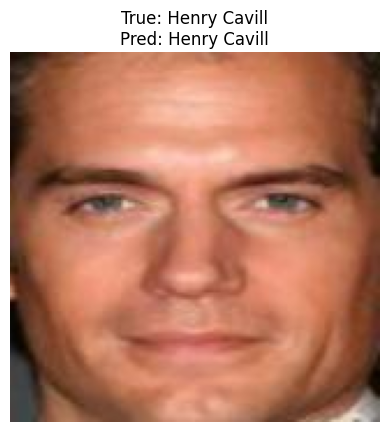

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


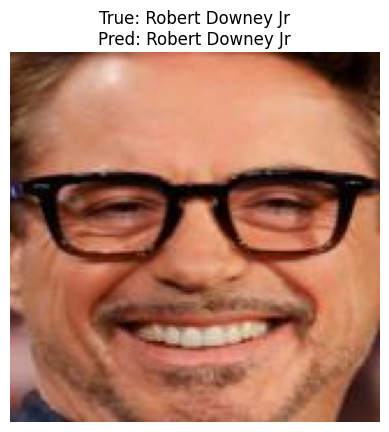

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


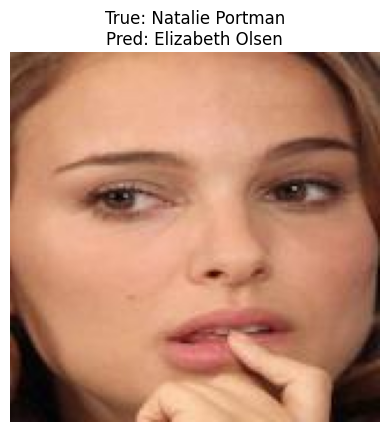

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


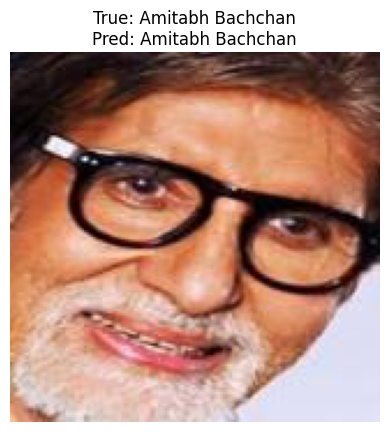

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


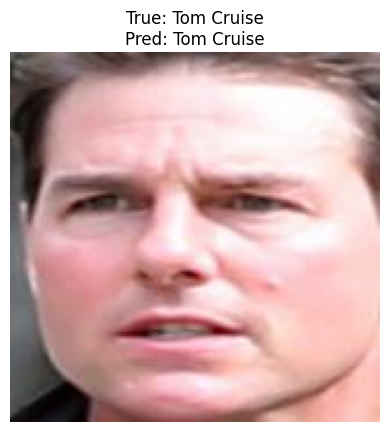

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load dataset labels
try:
    # Attempt to load from the Kaggle dataset path first
    df = pd.read_csv('/kaggle/input/face-recognition-dataset/Dataset.csv')
except FileNotFoundError:
    # If that fails, try loading from the current directory
    df = pd.read_csv('Dataset.csv')

# Invert class_indices mapping from generator
idx2label = {v: k for k, v in train_generator.class_indices.items()}

def preprocess_image(img_path, target_size=(160, 160)):
    img = Image.open(img_path).resize(target_size)
    
    # Convert image to grayscale explicitly
    img = img.convert('L')  # 'L' mode for grayscale
    
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    
    # Expand dimensions to add the channel axis (160, 160) -> (160, 160, 1)
    img_array = np.expand_dims(img_array, axis=-1)
    
    return img_array

def test_random_images(model, df, base_path, idx2label, num_samples=5, target_size=(160, 160)):
    sample_df = df.sample(num_samples)
    for _, row in sample_df.iterrows():
        # Compose full path using class folder + filename
        img_path = f"{base_path}/{row['id']}"
        true_label = row['label']
        
        # Open and display the original image
        original_img = Image.open(img_path)
        plt.imshow(original_img)
        
        # Preprocess the image for model prediction
        img_array = preprocess_image(img_path, target_size)
        
        # Make the prediction
        pred_probs = model.predict(np.expand_dims(img_array, axis=0))
        pred_index = np.argmax(pred_probs)
        pred_label = idx2label[pred_index]

        # Set the title and display the plot
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
        plt.show()


# Usage:
test_random_images(model, df, data_dir, idx2label)


### Conclusion : by using pretrained model such as  cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") we can extract faces and it can be possible to use in real time face recognition